In [26]:
ecowitt_key = 'insert key'
weather_key = 'insert key'

In [27]:
import requests
import os
# API URL
url = "https://api.ecowitt.net/api/v3/device/history"
# Parameters for the API request
params = {
    'application_key': '189DFA99311E08E814B19574C3AEE44F',
    'api_key': ecowitt_key,
    'start_date': '2024-02-04 00:00:00',
    'end_date': '2024-02-04 23:59:59',
    'mac': '7C:87:CE:BE:A8:3F',
    'call_back': 'temp_ch1'
}

# Make the request
response = requests.get(url, params=params)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    # Get the temperature data
    temperature_data = data['data']['temp_ch1']['temperature']['list']

    # Find the most recent temperature report
    most_recent_timestamp = max(temperature_data.keys())
    most_recent_temperature = temperature_data[most_recent_timestamp]

    # Print the result
    print(f"Most recent temperature report:")
    print(f"Timestamp: {most_recent_timestamp}")
    print(f"Temperature: {most_recent_temperature} °F")
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")


Most recent temperature report:
Timestamp: 1707108900
Temperature: 32.7 °F


In [28]:
import requests
import os
# API URL
url = "https://api.weather.com/v2/pws/history/daily"

# Parameters for the API request
params = {
    'stationId': 'KCTSTORR28',
    'format': 'json',
    'units': 'm',
    'date': '20231025',
    'apiKey': weather_key
}

# Make the request
response = requests.get(url, params=params)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    # Extract required data from the observations
    observations = data.get('observations', [])
    if observations:
        first_observation = observations[0]
        
        # Extracting 'art', 'prec', 'slrt', and 'wspd' from the metric data
        metric_data = first_observation.get('metric', {})
        airt = metric_data.get('tempAvg')
        prec = metric_data.get('precipTotal')
        slrt = metric_data.get('solarRadiationHigh')
        wspd = metric_data.get('windspeedAvg')

        airt = (airt * 9/5) + 32

        # Create an array 'data'
        data = {'airt': airt, 'prec': prec, 'slrt': slrt, 'wspd': wspd}

        # Print the result
        print("Data:")
        print(data)
    else:
        print("No observations available.")
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")


Data:
{'airt': 55.4, 'prec': 0.0, 'slrt': None, 'wspd': 0}


Mean Squared Error for Warm Season: 2.5184315211898
Mean Squared Error for Cold Season: 7.214492853274134


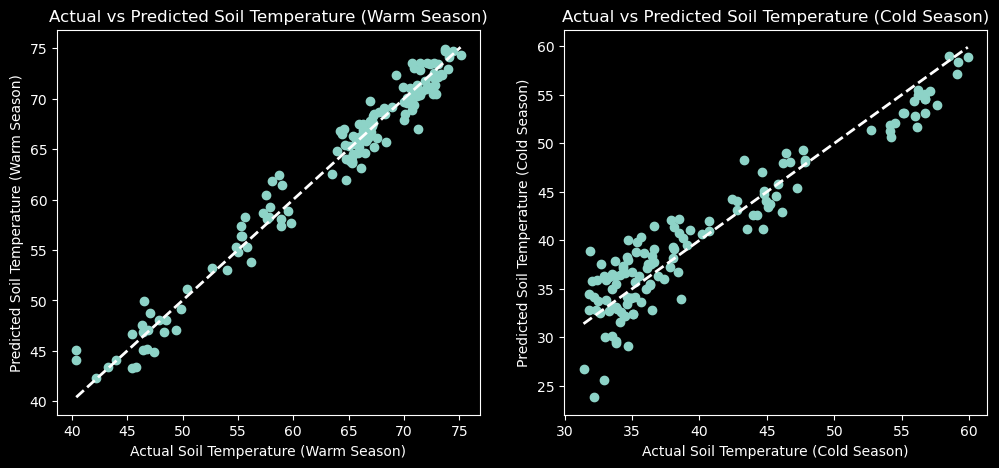

In [29]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

data = pd.read_csv('monthly.csv')

# making months for cold season/warm season
data['date'] = pd.to_datetime(data['date'])
warm_season = ['04', '05', '06', '07', '08', '09']
cold_season = ['10', '11', '12', '01', '02', '03']

# mapping months to warm/cold
data['month'] = data['date'].dt.month
data['season'] = data['month'].astype(str).str.zfill(2)
season_mapping = {1: 'cold', 2: 'cold', 3: 'cold', 4: 'warm', 5: 'warm', 6: 'warm', 7: 'warm', 8: 'warm', 9: 'warm', 10: 'cold', 11: 'cold', 12: 'cold'}
data['season'] = data['month'].map(season_mapping)

# dropping NaN values and extracting data to X and Y variables
data = data.dropna(subset=['s10t'])
X = data[['airt', 'prec', 'slrt', 'wspd']]
Y = data[['s10t']]

# segmenting data into seasons
warm_data = data[data['season'] == 'warm']
X_warm = warm_data[['airt', 'prec', 'slrt', 'wspd']]
Y_warm = warm_data[['s10t']]

cold_data = data[data['season'] == 'cold']
X_cold = cold_data[['airt','prec', 'slrt','wspd']]
Y_cold = cold_data[['s10t']]

# training for warm season
LRmodel_warm = LinearRegression()
LRmodel_warm.fit(X_warm, Y_warm)
LRpredict_warm = LRmodel_warm.predict(X_warm)

# training for cold season
LRmodel_cold = LinearRegression()
LRmodel_cold.fit(X_cold, Y_cold)
LRpredict_cold = LRmodel_cold.predict(X_cold)

# evaluate and plot
mse_warm = mean_squared_error(Y_warm, LRpredict_warm)
mse_cold = mean_squared_error(Y_cold, LRpredict_cold)
print(f'Mean Squared Error for Warm Season: {mse_warm}')
print(f'Mean Squared Error for Cold Season: {mse_cold}')

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Warm Season
axs[0].scatter(Y_warm, LRpredict_warm) 
axs[0].plot([Y_warm.min(), Y_warm.max()], [Y_warm.min(), Y_warm.max()], 'k--', color='white', lw=2)  # y = x line
axs[0].set_xlabel('Actual Soil Temperature (Warm Season)')
axs[0].set_ylabel('Predicted Soil Temperature (Warm Season)')
axs[0].set_title('Actual vs Predicted Soil Temperature (Warm Season)')

# Plot for Cold Season
axs[1].scatter(Y_cold, LRpredict_cold)
axs[1].plot([Y_cold.min(), Y_cold.max()], [Y_cold.min(), Y_cold.max()], 'k--', color='white', lw=2)  # y = x line
axs[1].set_xlabel('Actual Soil Temperature (Cold Season)')
axs[1].set_ylabel('Predicted Soil Temperature (Cold Season)')
axs[1].set_title('Actual vs Predicted Soil Temperature (Cold Season)')

plt.show()


In [30]:
import requests
import pandas as pd
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

# Assuming LRmodel_warm and LRmodel_cold are pre-trained models

# Function to fetch new data from the API
def fetch_new_weather_data():
    url = "https://api.weather.com/v2/pws/observations/current"
    params = {
        'stationId': 'KCTSTORR28',
        'format': 'json',
        'units': 'm',
        'apiKey': weather_key
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        return data.get('observations', [])
    else:
        print(f"Failed to fetch new data. Status code: {response.status_code}")
        return None

# Fetch new data from the API
new_data = fetch_new_weather_data()

if new_data:
    # Extract the required data from the first observation
    first_observation = new_data[0]
    
    # Extracting 'airt', 'prec', 'slrt', and 'wspd' from the metric data
    metric_data = first_observation.get('metric', {})
    airt = metric_data.get('tempAvg')
    prec = metric_data.get('precipTotal')
    slrt = metric_data.get('solarRadiationHigh')
    wspd = metric_data.get('windspeedAvg')

    # Replace None with 0 in the data
    airt = airt if airt is not None else 0
    prec = prec if prec is not None else 0
    slrt = slrt if slrt is not None else 0
    wspd = wspd if wspd is not None else 0

    # Create a DataFrame from the new data
    new_df = pd.DataFrame({'airt': [airt], 'prec': [prec], 'slrt': [slrt], 'wspd': [wspd]})

    # Use the pre-trained linear regression models for prediction
    LRpredict_warm = LRmodel_warm.predict(new_df)
    LRpredict_cold = LRmodel_cold.predict(new_df)

    # Print the predictions
    print("Predicted Soil Temperature for Warm Season:")
    print(LRpredict_warm[0])

    print("Predicted Soil Temperature for Cold Season:")
    print(LRpredict_cold[0])

    # Forecast for next week
    one_week_later = datetime.now() + timedelta(weeks=4)
    new_df_week = pd.DataFrame({
        'airt': [airt],
        'prec': [prec],
        'slrt': [slrt],
        'wspd': [wspd],
    })

    # Use the pre-trained models for forecasting next week
    forecast_week_warm = LRmodel_warm.predict(new_df_week)
    forecast_week_cold = LRmodel_cold.predict(new_df_week)

    # Print the forecast for next week
    print("\nForecast for Next Week:")
    print("Predicted Soil Temperature for Warm Season:")
    print(forecast_week_warm[0])

    print("Predicted Soil Temperature for Cold Season:")
    print(forecast_week_cold[0])
else:
    print("No new data available for testing.")


Predicted Soil Temperature for Warm Season:
[22.2365105]
Predicted Soil Temperature for Cold Season:
[34.54217389]

Forecast for Next Week:
Predicted Soil Temperature for Warm Season:
[22.2365105]
Predicted Soil Temperature for Cold Season:
[34.54217389]
